## Kaggel: Digit Recognizer(MNIST)  by Hyperopt + fit_generator()
Kaggle Digit recognizer: https://www.kaggle.com/c/digit-recognizer  
Hyperopt: https://github.com/hyperopt/hyperopt  

### Best Score: 0.99771
* max_evals= 10 (time: 1h 33m), score: 0.99771
* max_evals= 20 (time: --),  score: 
* max_evals= 30 (time: --),  score: 

Python 3.6  
NVIDIA GTX1060  

In [97]:
import warnings
warnings.filterwarnings('ignore')

import hyperopt
from hyperopt import hp, fmin, rand, tpe, Trials, space_eval, STATUS_OK

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import keras

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# fix random seed
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
seed = 123
rn.seed(seed)
np.random.seed(seed)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
tf.set_random_seed(seed)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print('tensorflow ver.:',tf.__version__)
print('keras ver.     : ', keras.__version__)
print('hyperopt ver.  :   ', hyperopt.__version__)

tensorflow ver.: 1.11.0
keras ver.     :  2.2.2
hyperopt ver.  :    0.2


## Data preparation: MNIST from Kaggle
* data split proportion: test_size=0.15

In [98]:
train = pd.read_csv('../train.csv')
label = train.label
train = train.drop(['label'], axis=1)
train = train.values.reshape(-1, 28, 28, 1)

x_train, x_test, y_train, y_test = train_test_split(train, label, test_size=0.15, shuffle=True, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(train, label, test_size=0.15, shuffle=True, random_state=seed)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_val = x_val.astype('float32') / 255.0

[x_train.shape, x_val.shape, x_test.shape]

[(35700, 28, 28, 1), (6300, 28, 28, 1), (6300, 28, 28, 1)]

## Hyperparameters for Hyperopt:  
* five Dropout rates

In [99]:
params = {
    'Dropout_0': hp.uniform('Dropout_0', 0.0, 0.5),
    'Dropout_1': hp.uniform('Dropout_1', 0.0, 0.5),
    'Dropout_2': hp.uniform('Dropout_2', 0.0, 0.5)
}

## CNN Model:
* return a dictionary includes at least 'loss' and 'status' for hyperopt
* the model pass -acc(negative accuracy) as a 'loss' value to the fmin()
* data augmentation: to use fit_generator() instead of fit()

In [100]:
batch_size = 32

cnt = 0
def cnn_model(params):
    
    initializer = keras.initializers.glorot_uniform(seed=seed)
    
    model = Sequential()  
    model.add(Conv2D(32, 3, activation='relu', kernel_initializer=initializer, input_shape=(28,28,1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, 3, activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Conv2D(32, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dropout(params['Dropout_0'], seed=seed))
    
    model.add(Conv2D(64, 3, activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 3, activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Conv2D(64, 4, strides=2, padding='same', activation='relu', kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dropout(params['Dropout_1'], seed=seed))

    model.add(Flatten())
    model.add(Dense(256, activation="relu", kernel_initializer=initializer))
    model.add(BatchNormalization())
    model.add(Dropout(params['Dropout_2'], seed=seed))
    
    model.add(Dense(10, activation = "softmax", kernel_initializer=initializer))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    datagen = ImageDataGenerator(rotation_range=10,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1,
                                 zoom_range=0.1)

    datagen.fit(x_train, seed=seed)

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

    hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                               epochs=50,
                               validation_data=(x_val, y_val),
                               steps_per_epoch=x_train.shape[0]//batch_size,
                               callbacks=[reduce_lr, early_stop],
                               verbose=2)

    loss = hist.history['val_loss'][-1]
    acc = hist.history['val_acc'][-1]

    global cnt
    print(cnt, ': Val loss:', loss, ': Val acc:', acc, '\n\n')
    cnt += 1
    
    return {'loss': -acc, 'status': STATUS_OK, 'model': model, 'hist': hist}
    

## Search the best Hyperparameters & the best model:

In [101]:
trials = Trials()
best = fmin(fn=cnn_model, 
            space=params, 
            algo=tpe.suggest, 
            max_evals=10, # 50: 5h 15m
            trials=trials,
            verbose=1,
            rstate=np.random.RandomState(seed))

best

Epoch 1/50
 - 27s - loss: 0.3667 - acc: 0.8860 - val_loss: 0.0668 - val_acc: 0.9810
Epoch 2/50
 - 18s - loss: 0.1195 - acc: 0.9632 - val_loss: 0.0747 - val_acc: 0.9784
Epoch 3/50
 - 18s - loss: 0.0975 - acc: 0.9699 - val_loss: 0.0300 - val_acc: 0.9905
Epoch 4/50
 - 18s - loss: 0.0805 - acc: 0.9753 - val_loss: 0.0336 - val_acc: 0.9883
Epoch 5/50
 - 18s - loss: 0.0763 - acc: 0.9767 - val_loss: 0.0271 - val_acc: 0.9913
Epoch 6/50
 - 18s - loss: 0.0695 - acc: 0.9788 - val_loss: 0.0300 - val_acc: 0.9902
Epoch 7/50
 - 19s - loss: 0.0629 - acc: 0.9821 - val_loss: 0.0250 - val_acc: 0.9919
Epoch 8/50
 - 18s - loss: 0.0586 - acc: 0.9820 - val_loss: 0.0196 - val_acc: 0.9937
Epoch 9/50
 - 18s - loss: 0.0525 - acc: 0.9843 - val_loss: 0.0194 - val_acc: 0.9925
Epoch 10/50
 - 17s - loss: 0.0510 - acc: 0.9849 - val_loss: 0.0216 - val_acc: 0.9929
Epoch 11/50
 - 18s - loss: 0.0480 - acc: 0.9858 - val_loss: 0.0199 - val_acc: 0.9925

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00050000002374

Epoch 2/50
 - 18s - loss: 0.1263 - acc: 0.9612 - val_loss: 0.0759 - val_acc: 0.9779
Epoch 3/50
 - 19s - loss: 0.0970 - acc: 0.9703 - val_loss: 0.0315 - val_acc: 0.9897
Epoch 4/50
 - 19s - loss: 0.0823 - acc: 0.9754 - val_loss: 0.0324 - val_acc: 0.9905
Epoch 5/50
 - 19s - loss: 0.0780 - acc: 0.9761 - val_loss: 0.0297 - val_acc: 0.9906
Epoch 6/50
 - 18s - loss: 0.0689 - acc: 0.9797 - val_loss: 0.0284 - val_acc: 0.9905
Epoch 7/50
 - 18s - loss: 0.0627 - acc: 0.9810 - val_loss: 0.0275 - val_acc: 0.9906
Epoch 8/50
 - 18s - loss: 0.0557 - acc: 0.9831 - val_loss: 0.0279 - val_acc: 0.9916
Epoch 9/50
 - 18s - loss: 0.0546 - acc: 0.9844 - val_loss: 0.0189 - val_acc: 0.9943
Epoch 10/50
 - 18s - loss: 0.0519 - acc: 0.9846 - val_loss: 0.0186 - val_acc: 0.9941
Epoch 11/50
 - 18s - loss: 0.0490 - acc: 0.9854 - val_loss: 0.0169 - val_acc: 0.9944
Epoch 12/50
 - 18s - loss: 0.0461 - acc: 0.9864 - val_loss: 0.0226 - val_acc: 0.9937
Epoch 13/50
 - 18s - loss: 0.0410 - acc: 0.9876 - val_loss: 0.0161 - val_

 - 19s - loss: 0.0137 - acc: 0.9958 - val_loss: 0.0106 - val_acc: 0.9971
Epoch 23/50
 - 19s - loss: 0.0129 - acc: 0.9962 - val_loss: 0.0102 - val_acc: 0.9968
Epoch 24/50
 - 19s - loss: 0.0123 - acc: 0.9964 - val_loss: 0.0092 - val_acc: 0.9975
Epoch 25/50
 - 19s - loss: 0.0133 - acc: 0.9960 - val_loss: 0.0098 - val_acc: 0.9970
Epoch 26/50
 - 19s - loss: 0.0124 - acc: 0.9961 - val_loss: 0.0100 - val_acc: 0.9973

Epoch 00026: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 27/50
 - 19s - loss: 0.0119 - acc: 0.9961 - val_loss: 0.0093 - val_acc: 0.9971
Epoch 28/50
 - 19s - loss: 0.0111 - acc: 0.9968 - val_loss: 0.0094 - val_acc: 0.9970

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 29/50
 - 19s - loss: 0.0105 - acc: 0.9972 - val_loss: 0.0093 - val_acc: 0.9971
Epoch 00029: early stopping
5 : Val loss: 0.009320736908689252 : Val acc: 0.9971428571428571 


Epoch 1/50
 - 29s - loss: 0.3562 - acc: 0.8888 - val_loss: 0.0545 - val_a

 - 19s - loss: 0.1065 - acc: 0.9667 - val_loss: 0.0502 - val_acc: 0.9852
Epoch 3/50
 - 19s - loss: 0.0857 - acc: 0.9739 - val_loss: 0.0278 - val_acc: 0.9903
Epoch 4/50
 - 19s - loss: 0.0730 - acc: 0.9772 - val_loss: 0.0342 - val_acc: 0.9892
Epoch 5/50
 - 19s - loss: 0.0675 - acc: 0.9798 - val_loss: 0.0430 - val_acc: 0.9868

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 6/50
 - 19s - loss: 0.0464 - acc: 0.9859 - val_loss: 0.0239 - val_acc: 0.9927
Epoch 7/50
 - 19s - loss: 0.0412 - acc: 0.9881 - val_loss: 0.0228 - val_acc: 0.9929
Epoch 8/50
 - 19s - loss: 0.0407 - acc: 0.9876 - val_loss: 0.0280 - val_acc: 0.9929
Epoch 9/50
 - 19s - loss: 0.0374 - acc: 0.9889 - val_loss: 0.0161 - val_acc: 0.9943
Epoch 10/50
 - 19s - loss: 0.0382 - acc: 0.9891 - val_loss: 0.0161 - val_acc: 0.9956
Epoch 11/50
 - 19s - loss: 0.0357 - acc: 0.9895 - val_loss: 0.0122 - val_acc: 0.9970
Epoch 12/50
 - 19s - loss: 0.0324 - acc: 0.9900 - val_loss: 0.0154 - val_acc: 0.9948
Epo

{'Dropout_0': 0.3272449405085721,
 'Dropout_1': 0.2919607928329454,
 'Dropout_2': 0.20616325689743176}

## Best Hyperparameters:

In [102]:
space_eval(params, best)

{'Dropout_0': 0.3272449405085721,
 'Dropout_1': 0.2919607928329454,
 'Dropout_2': 0.20616325689743176}

## Best Result

In [103]:
trials.best_trial['result']

{'hist': <keras.callbacks.History at 0x7f55181e7ef0>,
 'loss': -0.9977777777777778,
 'model': <keras.engine.sequential.Sequential at 0x7f555d038f98>,
 'status': 'ok'}

## Best model:

In [104]:
best_model = trials.best_trial['result']['model']
#best_model.save('hyperopt_mnist_best_model.hdf5')

## Evaluation on Test data:

In [105]:
score = best_model.evaluate(x_test, y_test, verbose=1)
score

6300/6300 [==============================] - 2s 313us/step


[0.008627809460578848, 0.9977777777777778]

## Prediction for the Submission:

In [106]:
test = pd.read_csv('../test.csv')
test_index = test.index
test = test.values.reshape(-1, 28, 28, 1).astype('float32') / 255.0

pred = best_model.predict(test, verbose=1)
result = pred.argmax(axis=1)

28000/28000 [==============================] - 12s 434us/step


## Output the Submission csv file:

In [107]:
submission = pd.DataFrame({'ImageId': test_index+1, 'Label': result})
submission.to_csv('hyperopt_gen_sim.csv', index=False)

#### Comparison with the previous result scored at 0.99700

In [108]:
prev_result = pd.read_csv('hyperopt_gen_sim_99700.csv', index_col=0)
curr_result = pd.read_csv('hyperopt_gen_sim.csv', index_col=0)
match_num = np.sum(prev_result.Label.values == curr_result.Label.values)
comp_acc = match_num / len(curr_result)
print('Approx. accuracy: {0:.5f}'.format(comp_acc))

Approx. accuracy: 0.99750


Difference: 70
Image Title: [previous result, current result, id number]


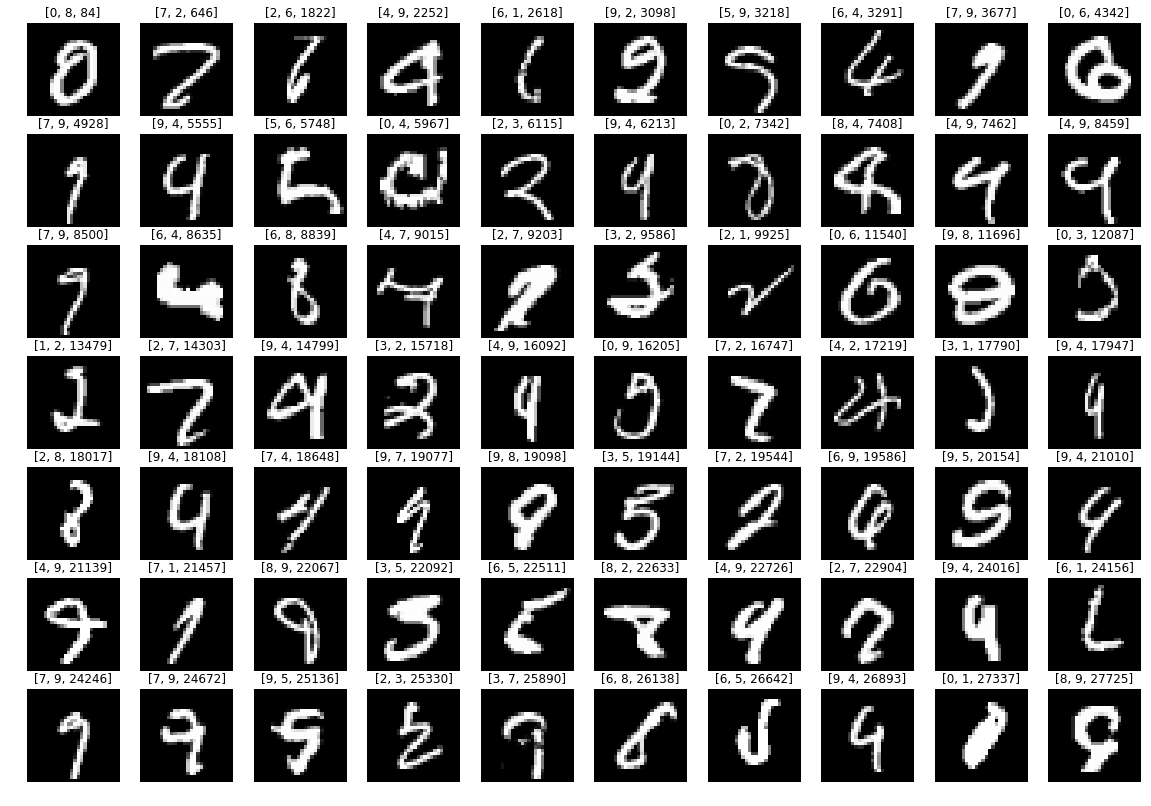

In [109]:
idx = prev_result[prev_result.Label.values != curr_result.Label.values].index
num=len(idx)
print('Difference:',num)
print('Image Title: [previous result, current result, id number]')

fig = plt.figure(figsize=(20, (num//10+1)*2))
for n in range(num):
    plt.subplot(num//10+1, 10, n+1)
    img = test[idx[n]-1].reshape(28,28)
    plt.imshow(img, cmap='gray')
    plt.title([prev_result.loc[idx[n]].Label, curr_result.loc[idx[n]].Label, idx[n]])
    plt.axis('off')
plt.show()